#Lab 3: Quantization and predictive coding

#Introduction
The goal of this lab is to get familiar with how to perform a quantization
process and learn how to do video compression through the predictive coding
technique.

Please follow these steps to prepare for the tasks:
1. Download the given video file in the course files and add it to the project files.
2. Import the libraries below.


In [2]:
#LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pylab

#Tasks
Task 0. Twice the greyscale conversion
1. Extract frame number 80 and 85 from your video file
2. Convert both frames from RGB to YUV by using your function
“frameRGB2YUV”. In the rest of the lab we will only work on the Y layers of the two frames. The Y layers will from now on be referred to as 'the frames.''


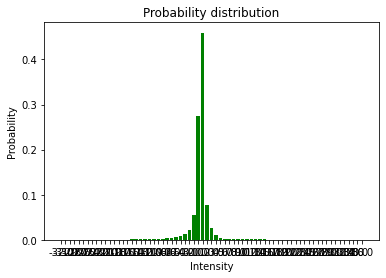

Entropy:  2.510419730304523
45.60602713000775


Text(0.5, 1.0, 'Reconstructed frame 85')

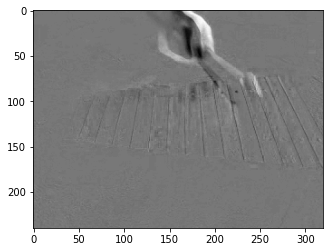

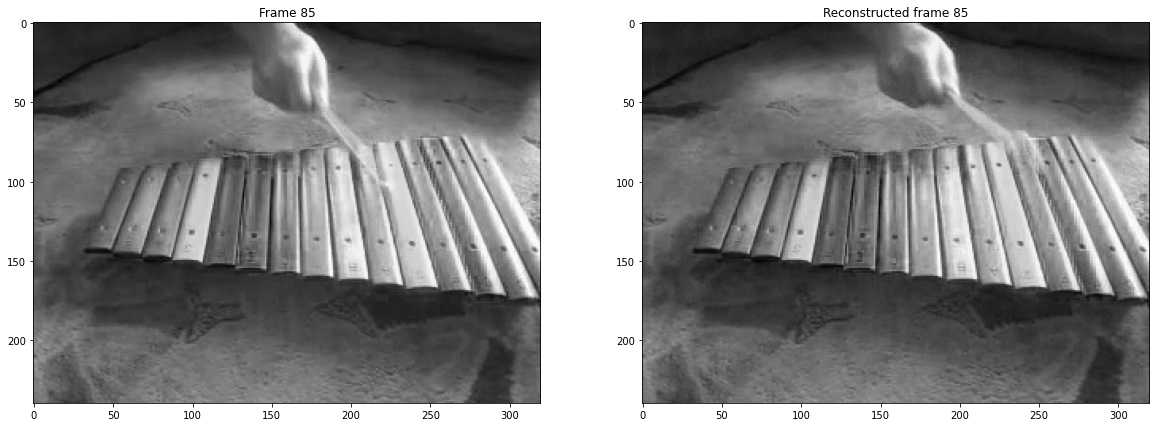

In [12]:
#VIDEO


# Set up to read video. Set string to name of your clip.
cap = cv2.VideoCapture('test_video.mp4')

if cap.isOpened() == False:
    print("That's probably not the name of your clip")

# Some information about the video file
cap_e = int(cap.get(0)) # Elapsed video time in milliseconds
cap_w = int(cap.get(3)) # Frame width
cap_h = int(cap.get(4)) # Frame height
cap_r = int(cap.get(5)) # Frame rate
cap_l = int(cap.get(7)) # Length in number of frames
# Under VideoCapture::get is a list of attributes
# https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-open

# Reads frame number 80 and 85
stop = 80
stop_2 = 85

frame_80 = []
frame_85 = []
for i in range(stop_2):
    ret, frame = cap.read()

    if i == stop-1:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        YUVframe = np.rint(frameRGB2YUV(frame))
        frame_80 = YUVframe[:,:,0]

    if i == stop_2-1:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        YUVframe = np.rint(frameRGB2YUV(frame))
        frame_85 = YUVframe[:,:,0]

dim = frame_80.shape
diff_image, diff_dict = Diffimage(frame_80, frame_85)
diff_dict = Huffmandict(diff_dict)
#print(diff_dict)
encoded = Huffmanenco(diff_image, diff_dict)
decoded = Huffmandeco(encoded, diff_dict)
#print(decoded)

reconstructed = Reconsimage(frame_80, diff_image)
print(CalculatePSNR(reconstructed, frame_85))

plt.imshow(diff_image, cmap='gray')

f, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(frame_80, cmap='gray')
ax[0].set_title("Frame 85")

ax[1].imshow(reconstructed, cmap="gray")
ax[1].set_title("Reconstructed frame 85")

In [3]:
#RGB2YUV

def frameRGB2YUV(RGBframe):
  # Transform RGB to YUV
  imagearray = np.array(RGBframe)
  imagearray = imagearray.astype("uint8")
  transform_matrix = np.array([[0.2126, 0.7152, 0.0722], [-0.09991, -0.33609, 0.436], [0.615, -0.55861, -0.05639]])
  YUVframe = np.matmul(imagearray, transform_matrix)
  y, u, v = cv2.split(YUVframe)

  # Downsamples/Upsamples
  dim_down = (int(u.shape[1] / 2), int(u.shape[0] / 2))
  dim_up = (int(u.shape[1]), int(u.shape[0]))
  
  u_comp = cv2.resize(cv2.resize(u, dim_down), dim_up)
  v_comp = cv2.resize(cv2.resize(v, dim_down), dim_up)

  YUVframe = cv2.merge((y, u_comp, v_comp))
  return YUVframe

Task 1. Differential Video Coding
1. Write a new function, “Diffimage” that calculates the frame
difference between frame 85 and 80. You can use this formula(d = frame difference): $$d = frame_{85}- frame_{80}$$ 
2. "DiffImage" should then quantize the frame difference with a quantization step size of 4. Hint: divide and round down. You will multiply at a later stage.
3. Compute the entropy of the Y frame difference by using the Calcent function.



In [4]:
#IMAGE DIFFERENCE
def Diffimage(frame1, frame2):
  d = frame2 - frame1
  d = np.floor(d/4)
  return d, Calcent(d)
  

In [5]:
#ENTROPY
def Calcent(input):

  dictionary = {}
  
  value, counts = np.unique(input, return_counts=True)

  entropy = 0
  for i in value:
    dictionary[str(i)] = int(counts[value == i]) / input.size
      

    entropy += dictionary[str(i)] * np.log2(dictionary[str(i)])

  entropy *= -1
  
  # Plot the probability distribution
  plt.bar(dictionary.keys(), dictionary.values(), color='g')
  plt.xlabel('Intensity')
  plt.ylabel('Probability')
  plt.title('Probability distribution')
  #plt.locator_params(nbins=20)
  plt.show()
  
  print("Entropy: ", entropy)
  return(dictionary)
 

Task 2. Huffman Coding

Here you will perform Huffman coding on the frame difference.
1. Construct a Huffman codebook for the quantized Y frame difference 
2. Perform Huffman encoding and decoding of the Y frame
difference


In [6]:
import numpy as np
#HUFFMAN DICTIONARY

#!!!IMPORTANT!!! MAKE SURE THAT YOUR DICTIONARY'S NAME IS p

def Huffmandict(p):
  
  # This function generates a binary Huffman code dictionary 
  # Input should be a dictionary where the keys are the pixel intensities that
  # are found in your frame and the value of each key is the probability of 
  # that intensity to appear (i.e. FrequencyOfIntensity/TotalNumberOfPixels)
  # Consider this example: input = {'255':0.0312, '254':0.0000829, et cetera}
  # Output will be a dictionary where the keys are the pixel intensities 
  # found in your input dictionary, and the values are the binary codes for
  # the keys.

    '''Return a Huffman code for an ensemble with distribution p.'''
    normalizationFactor = sum(p.values())
    for k in p.keys():
      p[k] = p[k] / normalizationFactor
    EPSILON = 0.0001
    assert(sum(p.values()) < 1.0 + EPSILON) # Ensure probabilities sum to 1
    assert(sum(p.values()) > 1.0 - EPSILON) # Ensure probabilities sum to 1
    # Base case of only two symbols, assign 0 or 1 arbitrarily
    if len(p) == 2:
        return dict(zip(p.keys(), "01"))
    # Create a new distribution by merging lowest prob. pair
    p_prime = p.copy()
    a1, a2 = lowest_prob_pair(p)
    p1, p2 = p_prime.pop(a1), p_prime.pop(a2)
    p_prime[str(a1) + '|' + str(a2)] = p1 + p2
    # Recurse and construct code on new distribution
    c = Huffmandict(p_prime)
    ca1a2 = c.pop(str(a1) + '|' + str(a2))
    c[str(a1)], c[str(a2)] = ca1a2 + '0', ca1a2 + '1'
    return c
    
def lowest_prob_pair(p):
    '''Return pair of symbols from distribution p with lowest probabilities.'''
    assert(len(p) >= 2) # Ensure there are at least 2 symbols in the dist.

    sorted_p = sorted(p.items(), key=lambda x: x[1])

    return sorted_p[0][0], sorted_p[1][0]



In [8]:
#HUFFMAN ENCODING 
def Huffmanenco(OriginalImage, Huffdict):
  
  output = []
  for i in range(OriginalImage.shape[0]):
    for j in range(OriginalImage.shape[1]):
      output.append(Huffdict[str(OriginalImage[i,j])])

  return output
  


In [9]:
#HUFFMAN DECODING
def Huffmandeco(EncodedImage, Huffdict):
    
  output = np.zeros(shape=dim)

  keys = list(Huffdict.keys())
  values = list(Huffdict.values())

  for i in range(dim[0]):
    for j in range(dim[1]):
        output[i,j] = keys[values.index(EncodedImage[i*dim[1]+j])]
  
  return output


Task 3. Reconstruction
1. Reconstruct Y frame 85 by writing a new function “Reconsimage” ,
which will first perform an inverse quantization on the frame difference (Hint: multiply.) and then reconstruct frame 85 by adding the frame difference to frame 80. You can use this formula (d = frame difference): $$frame_{85} = frame_{80} + d$$
2. Compute the quality of the reconstructed frame 85 by using your function
‘CalculatePSNR’. Use the original frame 85 and your reconstructed frame 85 as input.

In [10]:
#RECONSTRUCT
def Reconsimage(frame, framedifference):
  framedifference *= 4
  output = np.zeros(shape=dim)
  for i in range(dim[0]):
    for j in range(dim[1]):
      output[i,j] = framedifference[i,j] + frame[i,j]
  return output
  


In [11]:
#PSNR
def CalculatePSNR(im1, im2): 
    if im1.shape == im2.shape:
        return 10 * np.log10(255**2 / (np.mean(im1) - np.mean(im2))**2)



#Report
In your report, you need to 
1. Show frame 85 side by side with its
reconstructed version. 
2. Show the frame difference between Y
frame 80 and 85, show the probability distributions of the frame difference, and
give its entropy.
3. Give PSNR of the reconstructed Y frame 85

Note: Upload your group member names, your report and your notebook all as an one .pdf just like in previous labs.

Upload your report to “Assignments/Lab3”.

Deadline is 6 May 2021 23:59